# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, RMSProp, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения, c различными гиперпараметрами (коэффициент обучения и betas)
    * SGD, SGD+momentum, Adam
    
За все три задания 1 бал, срок выполнения 2 недели, после 0.5 бала.

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку pytorch. Получаем на вход тензор размером $(B, C_{in}, H, W)$, на выходе получаем тензор $(B, C_{out}, H_{out}, W_{out})$.
$$
B \ - \ размерность\ батча. \\
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки:
$$
\begin{equation*}
\text{out}(B_i, C_{out_j}) = \text{bias}(C_{out_j}) +
                        \sum_{k = 0}^{C_{in} - 1} \text{kernel}(C_{out_j}, k) \star \text{x}(B_i, k)
\end{equation*},
$$

где $\large k $ - ядро свертки, с парамерами $C_{in}, H_k, W_k, stride_{H,W}, padding_{H,W}  $.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [1]:
import torch
import torch.nn.functional as F

In [2]:
# прототип функции 
def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):
    """
    Arguments:
    :param  x: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d, тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда
    :param  padding:  tuple - параметры паддинга
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
    if len(x.size())==3:
        x = x.unsqueeze(0)
    batch_size, canal_size, height_input, width_input = x.size()
    
    height_output = (height_input + 2*padding[0] - kernel.size()[1])/stride[0] + 1
    width_output = (width_input + 2*padding[1] - kernel.size()[2])/stride[1] + 1
    assert height_output.is_integer(), "Height is not integer!"
    assert width_output.is_integer(), "Width is not integer!"
    
    height_output = int(height_output)
    width_output = int(width_output)
    batch_size = int(batch_size)
    
    x_output = torch.FloatTensor(batch_size, height_output, width_output)
    
    
    
    padding_param = (0,0, 0,0, padding[0],padding[0], padding[1],padding[1])
    x_padding = F.pad(x, padding_param, "constant", 0)
    
    for i in range(batch_size):
        for j in range (height_output):
            for k in range(width_output):
                sv = 0
                for k0 in range(kernel.size()[0]):
                    for k1 in range(kernel.size()[1]):
                        for k2 in range(kernel.size()[2]):
                            a = kernel[k0][k1][k2]
                            b = x_padding[i][k0][(j)*stride[0]+k1][(k)*stride[1]+k2]
                            sv+=a*b
                x_output[i][j][k] = sv
    if bias is not None:
        for i in range(batch_size):
            x_output[i] = x_output[i] + bias
    if len(x_output.size())==3 and x_output.size()[0]==1:
        x_output = x_output.squeeze(0)
    return x_output

In [3]:
t = torch.randn(3,3,3)
kernel = torch.FloatTensor(3,2,2)
kernel.fill_(1.)
bias = torch.FloatTensor(2,2)
bias.fill_(0.)
print(t)
print(my_conv2d(t, kernel, stride=(1,1), bias = bias ))

tensor([[[ 0.9352, -0.7399, -1.4752],
         [ 0.0600,  0.2025, -0.4206],
         [-0.7018, -1.4497,  0.7810]],

        [[ 0.5665, -2.9867,  0.7278],
         [ 1.0267, -0.5769, -0.8110],
         [ 0.4093,  1.0904, -0.5238]],

        [[ 0.1036,  1.5918,  2.3592],
         [-0.8325,  1.5467,  1.0843],
         [-1.7894, -1.1650,  0.5260]]])
tensor([[ 0.8969,  0.5019],
        [-2.1797,  0.2840]])


## Тестируем функцию свертки

### Загружаем картинку 

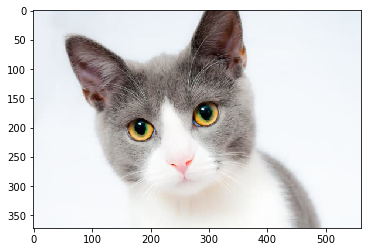

In [4]:
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [5]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [6]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

torch.Size([370, 558])


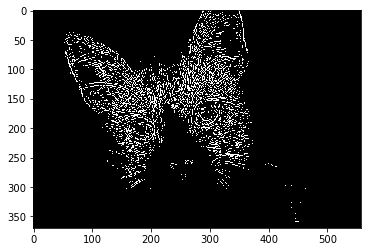

In [7]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [8]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


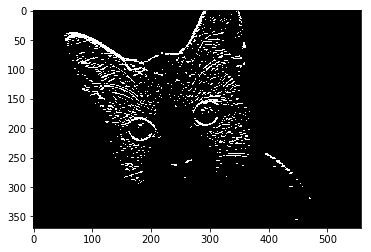

In [9]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [10]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


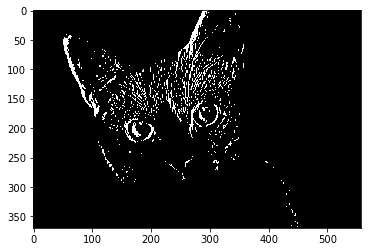

In [11]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([186, 280])


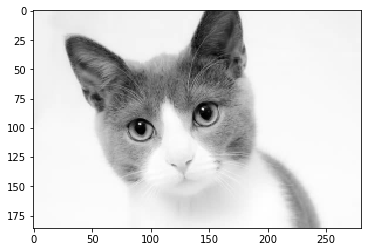

In [12]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Ядро свертки с гаусовым распределением

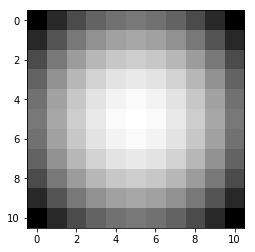

In [13]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

torch.Size([362, 550])


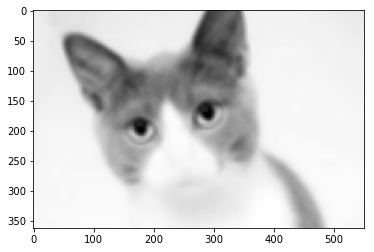

In [14]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

# 2. Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} - (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} - (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \gamma, b $ - параметры расчитанные в процессе тренировки слоя.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй

Нужные функции
```python
import torch
torch.zeros #- создать тензор заполненный нулями
torch.ones #- создать тензор заполненный единицами
torch.Tensor #- создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  #- среднее и дисперсия
x.uniform_ #- заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) #- разширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1 
```

In [6]:
import torch.nn as nn

class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta=0.9, epsilon=1e-8):
        """
        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        super().__init__()
        self.in_channels = in_channels
        self.afine = afine
        self.beta = beta
        self.epsilon = epsilon
        self.moving_avg = torch.zeros(in_channels)
        self.moving_var = torch.ones(in_channels)
        if afine:
            self.gamma = torch.Tensor(1, in_channels, 1, 1).fill_(1.)
            self.b = torch.Tensor(1, in_channels, 1, 1).fill_(0.)
        else: 
            self.gamma = None
            self.b = None
        
    def forward(self, x):
        """
        Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
        """
        features = torch.reshape(x, (x.size(1),-1))
        
        if self.training:
            
            avg = torch.mean(features, dim=1)
            var = torch.var(features, dim=1)
                
            self.moving_avg = self.beta*self.moving_avg + avg*(1. - self.beta)
            self.moving_var = self.beta*self.moving_var + var*(1. - self.beta)
    
        mean = self.moving_avg.unsqueeze(-1).unsqueeze(-1).expand_as(x)
        
        std = torch.sqrt(self.moving_var+self.epsilon)
        std = std.unsqueeze(-1).unsqueeze(-1).expand_as(x)
        gamma = 1.
        b = 0.
        if self.gamma is not None:
            gamma = self.gamma
        if self.b is not None:
            b = self.b
        
        tmp = (x - mean)/std*gamma + b
        
        return tmp

### Проверяем работу батч нормадлизации на котэ

torch.Size([3, 372, 560])


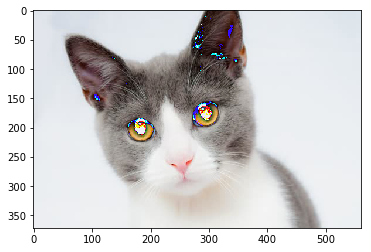

In [7]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

torch.Size([3, 372, 560])


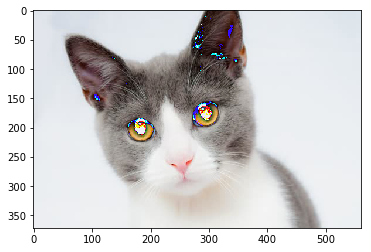

In [8]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
bn = BatchNorm2d(3, afine=True)
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

Так получилось потому что я использовал корректировку начальных весов

### Проверим как реализация работает на большом сете картинок

In [9]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [10]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


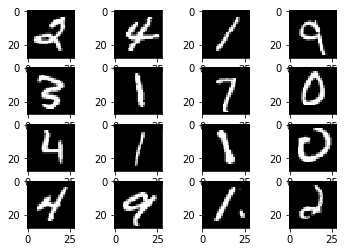

In [11]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются средние значения в процессе тренировки

In [12]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [ bn.moving_avg.mean() ] 
            var_curve +=  [ bn.moving_var.mean() ]
    return mean_curve, var_curve

In [13]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

Смотрим какие значения средних и дисперсий у нас получились

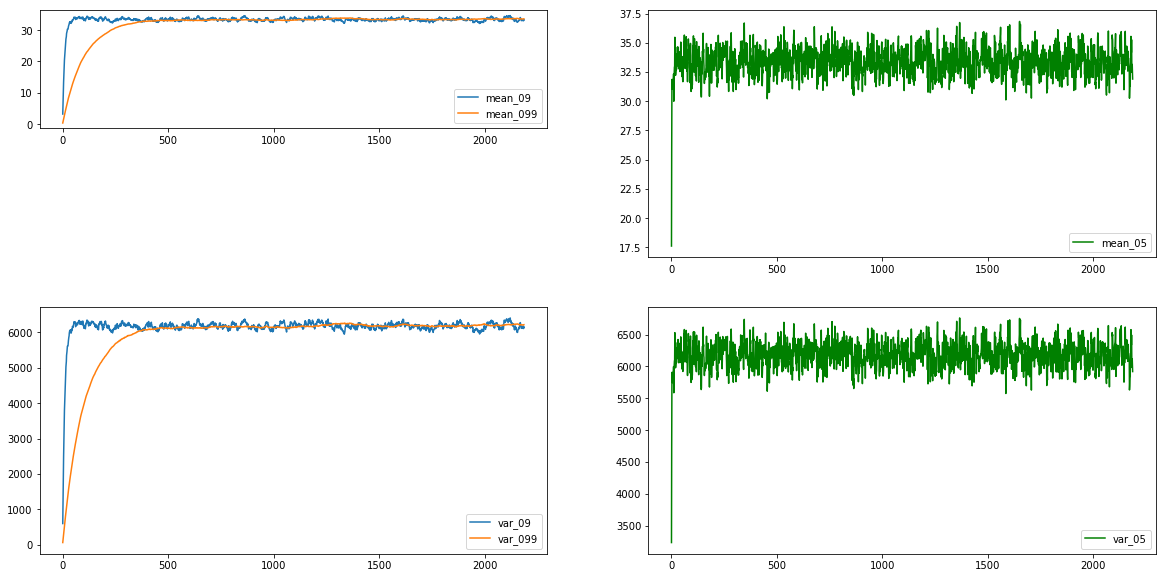

In [14]:
plt.figure(figsize=(20,10))
ax = plt.subplot(4,2,1)
ax.plot(mean_curve_09,label="mean_09")
ax.plot(mean_curve_099,label="mean_099")
ax.legend()
ax = plt.subplot(2,2,2)
ax.plot(mean_curve_05,label="mean_05",  color='g')
ax.legend()
ax = plt.subplot(2,2,3)
ax.plot(var_curve_09,label="var_09",)
ax.plot(var_curve_099,label="var_099",)
ax.legend()
ax = plt.subplot(2,2,4)
ax.plot(var_curve_05,label="var_05",  color='g')
ax.legend()

Посмотрим как повлияла батч нормализация на изображения

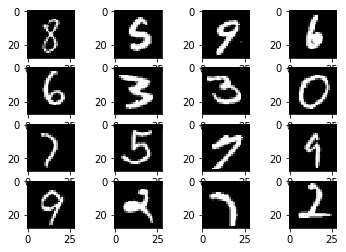

In [15]:
n=4
bn = bn_09
bn.train(False)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0)).squeeze(0).squeeze()
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), сделать выводы


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \times \ m_{t-1} + (1 - \alpha)\times g - момент \\ 
v_t &= \beta \times v_{t-1} +  (1-\beta)\times g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\times \hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^\frac{1}{2}}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$

Полезные функции

```python
import torch
torch.zeros_like(x)  # сделать тензор нулей такойже как x
tensor.addcmul_, addcdiv_, mul_  # все функции операции с тензорами, которые заканчиваются на _ присваивают результат в self тензор 
```


In [16]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] # betas
            eps = group['eps'] # эпсилон
            lr = group['lr'] # коэффициент обучения
            
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                    
                # забираем тензор градиента    
                grad = p.grad.data
                # сами параметры для обновления лежат тут
                # p.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['avg'] = torch.zeros_like(p.data) #todo може быть size of grad not a p.data
                    # скользящее среднее по квадрату градиентов
                    state['avg_sq'] = torch.zeros_like(p.data) # нужно проинициализировать TODO

                # тут можем достать сохраненные состояния
                exp_avg, exp_avg_sq = state['avg'], state['avg_sq']
                        
                # запоминаем шаг 
                state['step'] += 1

                # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                exp_avg.mul_(beta1).add_(1.-beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1.-beta2, grad, grad)
                step_size = lr*(1.-beta2**state['step'])**0.5/(1.-beta1**state['step'])
                denominator = exp_avg_sq.sqrt().add(eps)

                # обновляем веса в p.data, 
                p.data.addcdiv_(-step_size, exp_avg, denominator)

        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta \times m_{t-1} - (1- \beta) \times g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha \times m_{t-1} - \lambda \times g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [17]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания, если 0, получаем обычный SGD
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                # gradient                                
                grad = p.grad.data
                state = self.state[p]
                
                if beta != 0:
                    if len(state) == 0:
                        # скользящее среднее по градинтам
                        state['avg'] = torch.zeros_like(p.data)
                    # тут добавляем момент если он указан
                    state['avg'].mul_(beta).add_(1.-beta, grad)
                    grad = state['avg']

                # обновляем веса
                p.data.add_(-lr, grad)

        return loss


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [18]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [19]:
USE_CUDA=True

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))
            

        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24+2-3)/2+1 = 13, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            

        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))                  
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        return x

## Функция обучения модели

In [21]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss[0] )
            loss.backward() # <-- тут расчитывается градиент
            optimizer.step()  # <-- тут происходит обновление весов
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [22]:
learning_rate = 5e-1 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net #№ если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd1 = fit_net(20, net, optimizer) # обучаем сеть

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.11435218626198074
Do epoch 1 with loss 0.051855768093683426
Do epoch 2 with loss 0.04321145002781718
Do epoch 3 with loss 0.03703963927239875
Do epoch 4 with loss 0.03321074115927491
Do epoch 5 with loss 0.029258848289321644
Do epoch 6 with loss 0.02802140678602318
Do epoch 7 with loss 0.027376594325969575
Do epoch 8 with loss 0.02435858477167632
Do epoch 9 with loss 0.023951143329553424
Do epoch 10 with loss 0.023302742541108874
Do epoch 11 with loss 0.02153671042296131
Do epoch 12 with loss 0.018994867539345865
Do epoch 13 with loss 0.0209135139539027
Do epoch 14 with loss 0.02012952818451377
Do epoch 15 with loss 0.01902268774497438
Do epoch 16 with loss 0.0193626454255872
Do epoch 17 with loss 0.017064465791545722
Do epoch 18 with loss 0.016257639935177978
Do epoch 19 with loss 0.019266903645707746


In [23]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net #№ если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd2 = fit_net(20, net, optimizer) # обучаем сеть

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.10995941244961739
Do epoch 1 with loss 0.047009633323428945
Do epoch 2 with loss 0.036610487523174855
Do epoch 3 with loss 0.030347221154952954
Do epoch 4 with loss 0.02575408649270154
Do epoch 5 with loss 0.023651986353518378
Do epoch 6 with loss 0.02078323418834082
Do epoch 7 with loss 0.017751890343239606
Do epoch 8 with loss 0.015267643442179004
Do epoch 9 with loss 0.01490895997581277
Do epoch 10 with loss 0.014145744650206939
Do epoch 11 with loss 0.011890432212687433
Do epoch 12 with loss 0.011026777098807887
Do epoch 13 with loss 0.00979019291988507
Do epoch 14 with loss 0.009005342920621237
Do epoch 15 with loss 0.008107697638028497
Do epoch 16 with loss 0.006896857010429724
Do epoch 17 with loss 0.007567886871238468
Do epoch 18 with loss 0.0071593749779351075
Do epoch 19 with loss 0.006873124945528932


In [24]:
learning_rate = 5e-2 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net #№ если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd3 = fit_net(20, net, optimizer) # обучаем сеть

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.15746736887946322
Do epoch 1 with loss 0.04611076757986359
Do epoch 2 with loss 0.03547279355143868
Do epoch 3 with loss 0.028899909636311515
Do epoch 4 with loss 0.025128881930351038
Do epoch 5 with loss 0.022630643867770448
Do epoch 6 with loss 0.020531402002282484
Do epoch 7 with loss 0.017590473490759942
Do epoch 8 with loss 0.016117628099959792
Do epoch 9 with loss 0.014596326381417786
Do epoch 10 with loss 0.01389012428509028
Do epoch 11 with loss 0.012566588079760377
Do epoch 12 with loss 0.011285902166617314
Do epoch 13 with loss 0.009819020132632576
Do epoch 14 with loss 0.008846633344084693
Do epoch 15 with loss 0.00876295128449709
Do epoch 16 with loss 0.007447783743675626
Do epoch 17 with loss 0.005803340917370556
Do epoch 18 with loss 0.005212649580382516
Do epoch 19 with loss 0.005139586604726222


In [26]:
learning_rate = 1e-2 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net #№ если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd4 = fit_net(20, net, optimizer) # обучаем сеть

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.2437996016921766
Do epoch 1 with loss 0.0754203819450473
Do epoch 2 with loss 0.056845431475400596
Do epoch 3 with loss 0.04702134826273802
Do epoch 4 with loss 0.04037918188580651
Do epoch 5 with loss 0.03576915727516915
Do epoch 6 with loss 0.031772774491317754
Do epoch 7 with loss 0.029465572091750374
Do epoch 8 with loss 0.026386376213117117
Do epoch 9 with loss 0.02451451247107454
Do epoch 10 with loss 0.02279039181404371
Do epoch 11 with loss 0.020520725395235778
Do epoch 12 with loss 0.019553551996304774
Do epoch 13 with loss 0.018774713426623978
Do epoch 14 with loss 0.01679558931731938
Do epoch 15 with loss 0.01612007923536667
Do epoch 16 with loss 0.015300353599782943
Do epoch 17 with loss 0.014219986790110654
Do epoch 18 with loss 0.013491968521665208
Do epoch 19 with loss 0.0125717388667851


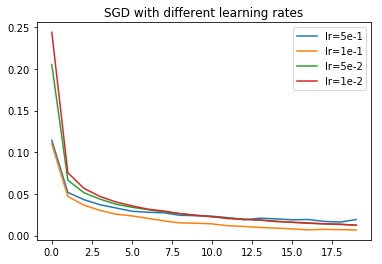

In [34]:
plt.plot(loss_curve_sgd1, label='lr=5e-1')
plt.plot(loss_curve_sgd2, label='lr=1e-1')
plt.plot(loss_curve_sgd3, label='lr=5e-2')
plt.plot(loss_curve_sgd4, label='lr=1e-2')
plt.title('SGD with different learning rates')
plt.legend()
plt.show()

## SGD с моментом

In [28]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum11 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.14702571910445308
Do epoch 1 with loss 0.04531633139855795
Do epoch 2 with loss 0.03587883493169345
Do epoch 3 with loss 0.029663633406979886
Do epoch 4 with loss 0.02618297288951451
Do epoch 5 with loss 0.022957904771086175
Do epoch 6 with loss 0.020258332220696944
Do epoch 7 with loss 0.0181650658775586
Do epoch 8 with loss 0.017476701203633184
Do epoch 9 with loss 0.016290838022345433
Do epoch 10 with loss 0.015189896180551238
Do epoch 11 with loss 0.01259206029981252
Do epoch 12 with loss 0.012468785909441
Do epoch 13 with loss 0.011416581916274902
Do epoch 14 with loss 0.011583759440479619
Do epoch 15 with loss 0.010035570879531986
Do epoch 16 with loss 0.009228068199068322
Do epoch 17 with loss 0.00830075470794539
Do epoch 18 with loss 0.007708381318070325
Do epoch 19 with loss 0.0074091702393053


In [29]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.5)
loss_curve_sgd_momentum12 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.121317578196035
Do epoch 1 with loss 0.048618681749280426
Do epoch 2 with loss 0.03787051861450778
Do epoch 3 with loss 0.031019796423569737
Do epoch 4 with loss 0.026642282885615553
Do epoch 5 with loss 0.0236410360304689
Do epoch 6 with loss 0.02045091470532293
Do epoch 7 with loss 0.018868837541349957
Do epoch 8 with loss 0.01719406829353986
Do epoch 9 with loss 0.01566182607363281
Do epoch 10 with loss 0.013949253479258131
Do epoch 11 with loss 0.013202941565547405
Do epoch 12 with loss 0.012697066994197412
Do epoch 13 with loss 0.011423194090225514
Do epoch 14 with loss 0.011349014733472152
Do epoch 15 with loss 0.010377523881499496
Do epoch 16 with loss 0.009101590641595807
Do epoch 17 with loss 0.00912347602882394
Do epoch 18 with loss 0.008209983320420444
Do epoch 19 with loss 0.007360326740286042


In [30]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.2)
loss_curve_sgd_momentum13 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.12046782788575704
Do epoch 1 with loss 0.05367427356762596
Do epoch 2 with loss 0.042325087549155524
Do epoch 3 with loss 0.035651986899853404
Do epoch 4 with loss 0.031615162504199004
Do epoch 5 with loss 0.028336525324495297
Do epoch 6 with loss 0.025296372975123545
Do epoch 7 with loss 0.0226071950918635
Do epoch 8 with loss 0.020204522802396947
Do epoch 9 with loss 0.01904535176045937
Do epoch 10 with loss 0.01832710152341178
Do epoch 11 with loss 0.016091496041909056
Do epoch 12 with loss 0.014189714055711077
Do epoch 13 with loss 0.013816010491402115
Do epoch 14 with loss 0.01286578359645308
Do epoch 15 with loss 0.010310356614657281
Do epoch 16 with loss 0.011468122300624193
Do epoch 17 with loss 0.009812963968905129
Do epoch 18 with loss 0.00906392530962709
Do epoch 19 with loss 0.008367305572958476


In [31]:
learning_rate = 5e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum21 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.13972139822861676
Do epoch 1 with loss 0.04649160956690505
Do epoch 2 with loss 0.03559429054397614
Do epoch 3 with loss 0.030206971947030495
Do epoch 4 with loss 0.026203255526377395
Do epoch 5 with loss 0.022547122900160033
Do epoch 6 with loss 0.021649279276093884
Do epoch 7 with loss 0.019056248995992873
Do epoch 8 with loss 0.01728883739279785
Do epoch 9 with loss 0.015235981922281568
Do epoch 10 with loss 0.013458562411016997
Do epoch 11 with loss 0.013182010172870968
Do epoch 12 with loss 0.011992217738660002
Do epoch 13 with loss 0.01143860528062455
Do epoch 14 with loss 0.009584243964211385
Do epoch 15 with loss 0.009144831123447985
Do epoch 16 with loss 0.009013656208272061
Do epoch 17 with loss 0.008770729213694104
Do epoch 18 with loss 0.006905126241881061
Do epoch 19 with loss 0.006921858528895524


In [32]:
learning_rate = 5e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.5)
loss_curve_sgd_momentum22 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.12634119684422568
Do epoch 1 with loss 0.04840316778797508
Do epoch 2 with loss 0.037756360362096085
Do epoch 3 with loss 0.031610521834955184
Do epoch 4 with loss 0.027414590321314297
Do epoch 5 with loss 0.02452575323390372
Do epoch 6 with loss 0.02154036061467784
Do epoch 7 with loss 0.019684689001073345
Do epoch 8 with loss 0.018045588373919844
Do epoch 9 with loss 0.016269579458220343
Do epoch 10 with loss 0.014933657444499102
Do epoch 11 with loss 0.012794195127149232
Do epoch 12 with loss 0.012151069087446908
Do epoch 13 with loss 0.010811463322032245
Do epoch 14 with loss 0.01054660870323565
Do epoch 15 with loss 0.008821802163538346
Do epoch 16 with loss 0.009261513136541893
Do epoch 17 with loss 0.007792275196267526
Do epoch 18 with loss 0.007661247367885051
Do epoch 19 with loss 0.007161441565268542


In [33]:
learning_rate = 5e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.2)
loss_curve_sgd_momentum23 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.1570082232492342
Do epoch 1 with loss 0.04556826694907257
Do epoch 2 with loss 0.03511121262684226
Do epoch 3 with loss 0.0289436427643842
Do epoch 4 with loss 0.025011616193054472
Do epoch 5 with loss 0.022609744304437643
Do epoch 6 with loss 0.01995816654097723
Do epoch 7 with loss 0.018091170082339753
Do epoch 8 with loss 0.016396831974870928
Do epoch 9 with loss 0.015104950789343456
Do epoch 10 with loss 0.012455899188329926
Do epoch 11 with loss 0.011677984020510492
Do epoch 12 with loss 0.010837700488799557
Do epoch 13 with loss 0.00965938747446996
Do epoch 14 with loss 0.009750187540087026
Do epoch 15 with loss 0.008563085722770656
Do epoch 16 with loss 0.008181134423655792
Do epoch 17 with loss 0.007456538117962119
Do epoch 18 with loss 0.006589313579793929
Do epoch 19 with loss 0.006036498224866079


## Adam

In [45]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam111 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.19358260275486894
Do epoch 1 with loss 0.045214915281024545
Do epoch 2 with loss 0.03525354962576237
Do epoch 3 with loss 0.030037984798760735
Do epoch 4 with loss 0.026898404640398124
Do epoch 5 with loss 0.02330476051059334
Do epoch 6 with loss 0.02031817120275489
Do epoch 7 with loss 0.018092607529974443
Do epoch 8 with loss 0.01657209568199198
Do epoch 9 with loss 0.015473816286607262
Do epoch 10 with loss 0.01348772165325062
Do epoch 11 with loss 0.012718771373538815
Do epoch 12 with loss 0.011540479474297712
Do epoch 13 with loss 0.011097814434663204
Do epoch 14 with loss 0.010102100769133671
Do epoch 15 with loss 0.009384645257276326
Do epoch 16 with loss 0.00816418405640981
Do epoch 17 with loss 0.00940040894496588
Do epoch 18 with loss 0.007489022754974217
Do epoch 19 with loss 0.00819195512976884


In [46]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.6))
loss_curve_adam121 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.6044895362618257
Do epoch 1 with loss 0.508110358094891
Do epoch 2 with loss 0.4988848219144873
Do epoch 3 with loss 0.4951007775536508
Do epoch 4 with loss 0.4917837730214974
Do epoch 5 with loss 0.4923150489080372
Do epoch 6 with loss 0.48941720649429693
Do epoch 7 with loss 0.49161341348956805
Do epoch 8 with loss 0.4883070154329332
Do epoch 9 with loss 0.489621997945893
Do epoch 10 with loss 0.4893047835015248
Do epoch 11 with loss 0.48713597452594204
Do epoch 12 with loss 0.4882464032223304
Do epoch 13 with loss 0.4858888278834123
Do epoch 14 with loss 0.49873981100541576
Do epoch 15 with loss 0.5015195937606642
Do epoch 16 with loss 0.6144725357458697
Do epoch 17 with loss 0.700601236633258
Do epoch 18 with loss 0.7005125296459277
Do epoch 19 with loss 0.7014322234960686


In [47]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.15))
loss_curve_adam131 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 3.503524534332736
Do epoch 1 with loss 2.3025848865509033
Do epoch 2 with loss 2.3025848865509033
Do epoch 3 with loss 2.3025848865509033
Do epoch 4 with loss 2.3025848865509033
Do epoch 5 with loss 2.3025848865509033
Do epoch 6 with loss 2.3025848865509033
Do epoch 7 with loss 2.3025848865509033
Do epoch 8 with loss 2.3025848865509033
Do epoch 9 with loss 2.3025848865509033
Do epoch 10 with loss 2.3025848865509033
Do epoch 11 with loss 2.3025848865509033
Do epoch 12 with loss 2.3025848865509033
Do epoch 13 with loss 2.3025848865509033
Do epoch 14 with loss 2.3025848865509033
Do epoch 15 with loss 2.3025848865509033
Do epoch 16 with loss 2.3025848865509033
Do epoch 17 with loss 2.3025848865509033
Do epoch 18 with loss 2.3025848865509033
Do epoch 19 with loss 2.3025848865509033


In [48]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.5, 0.999))
loss_curve_adam211 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.15148688406842345
Do epoch 1 with loss 0.050117999880783734
Do epoch 2 with loss 0.03887099352638417
Do epoch 3 with loss 0.03190194782692382
Do epoch 4 with loss 0.027428355413754345
Do epoch 5 with loss 0.024019472880155244
Do epoch 6 with loss 0.022094256399181483
Do epoch 7 with loss 0.01899554718083097
Do epoch 8 with loss 0.018262692313653232
Do epoch 9 with loss 0.015905683201826705
Do epoch 10 with loss 0.014813485060944969
Do epoch 11 with loss 0.013917443288424597
Do epoch 12 with loss 0.012549109937504759
Do epoch 13 with loss 0.01176532292521376
Do epoch 14 with loss 0.011346671640000826
Do epoch 15 with loss 0.009693657273318487
Do epoch 16 with loss 0.009619439696142757
Do epoch 17 with loss 0.009451770167891489
Do epoch 18 with loss 0.008996018857976646
Do epoch 19 with loss 0.007734333720717411


In [49]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.5, 0.6))
loss_curve_adam221 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.1406046142047897
Do epoch 1 with loss 0.05690999355833172
Do epoch 2 with loss 0.0472551326624705
Do epoch 3 with loss 0.04205018756327751
Do epoch 4 with loss 0.0366369950196271
Do epoch 5 with loss 0.03481687125198417
Do epoch 6 with loss 0.03135853345413485
Do epoch 7 with loss 0.029213986210916813
Do epoch 8 with loss 0.027222387584639185
Do epoch 9 with loss 0.02632680870030479
Do epoch 10 with loss 0.02375216227813458
Do epoch 11 with loss 0.02323918687422416
Do epoch 12 with loss 0.02130398452520425
Do epoch 13 with loss 0.020809075503410355
Do epoch 14 with loss 0.019652613106932768
Do epoch 15 with loss 0.01826809396584883
Do epoch 16 with loss 0.018010358700454643
Do epoch 17 with loss 0.018270285523300255
Do epoch 18 with loss 0.017064527787734887
Do epoch 19 with loss 0.01618462239205156


In [50]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.5, 0.15))
loss_curve_adam231 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.40325540238603863
Do epoch 1 with loss 0.2936605297022205
Do epoch 2 with loss 0.2867481369588219
Do epoch 3 with loss 0.28431263615755825
Do epoch 4 with loss 0.2822998356658354
Do epoch 5 with loss 0.2772122242704722
Do epoch 6 with loss 0.27625915271693785
Do epoch 7 with loss 0.2736982870088983
Do epoch 8 with loss 0.2733029464117512
Do epoch 9 with loss 0.2707344512069776
Do epoch 10 with loss 0.27127877162249053
Do epoch 11 with loss 0.2689362683022164
Do epoch 12 with loss 0.26774789114956665
Do epoch 13 with loss 0.26648699282019117
Do epoch 14 with loss 0.26601926093920214
Do epoch 15 with loss 0.2651062436779994
Do epoch 16 with loss 0.26683331498127577
Do epoch 17 with loss 0.2665227118693888
Do epoch 18 with loss 0.2641633022210344
Do epoch 19 with loss 0.26411297191215477


In [51]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.2, 0.999))
loss_curve_adam311 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.1523073389751485
Do epoch 1 with loss 0.051737190202512204
Do epoch 2 with loss 0.040609947700014276
Do epoch 3 with loss 0.034294340137782355
Do epoch 4 with loss 0.029105844440310853
Do epoch 5 with loss 0.02615478725113387
Do epoch 6 with loss 0.02362038982435073
Do epoch 7 with loss 0.020828396800750458
Do epoch 8 with loss 0.019151753341846395
Do epoch 9 with loss 0.01752152344681217
Do epoch 10 with loss 0.01626574882754573
Do epoch 11 with loss 0.014853928456185994
Do epoch 12 with loss 0.014895333143255184
Do epoch 13 with loss 0.012601122927818334
Do epoch 14 with loss 0.011885072274544928
Do epoch 15 with loss 0.011264133069086794
Do epoch 16 with loss 0.009624781653414483
Do epoch 17 with loss 0.01021729967040344
Do epoch 18 with loss 0.009384638338150038
Do epoch 19 with loss 0.009654945405613194


In [52]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.2, 0.6))
loss_curve_adam321 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.2065935241587368
Do epoch 1 with loss 0.05488781060360859
Do epoch 2 with loss 0.04402300513936713
Do epoch 3 with loss 0.037766554803814474
Do epoch 4 with loss 0.03443137218534374
Do epoch 5 with loss 0.03151644907029841
Do epoch 6 with loss 0.031160730636918387
Do epoch 7 with loss 0.02784419431771434
Do epoch 8 with loss 0.027041793625868234
Do epoch 9 with loss 0.02578695079760569
Do epoch 10 with loss 0.024687773389226505
Do epoch 11 with loss 0.024258478912156524
Do epoch 12 with loss 0.023405670588235634
Do epoch 13 with loss 0.02148603727324782
Do epoch 14 with loss 0.02112545217478935
Do epoch 15 with loss 0.019512427733145623
Do epoch 16 with loss 0.018864994607167423
Do epoch 17 with loss 0.020906767967592704
Do epoch 18 with loss 0.018412433961550286
Do epoch 19 with loss 0.018027137763965168


In [53]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.2, 0.15))
loss_curve_adam331 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.21542327358780466
Do epoch 1 with loss 0.06737333608712025
Do epoch 2 with loss 0.05888709557938096
Do epoch 3 with loss 0.05500395674212479
Do epoch 4 with loss 0.051365318830339235
Do epoch 5 with loss 0.049347419223599524
Do epoch 6 with loss 0.047861280894928124
Do epoch 7 with loss 0.04423713131846496
Do epoch 8 with loss 0.04336687474318656
Do epoch 9 with loss 0.04202659504942061
Do epoch 10 with loss 0.04327344250191168
Do epoch 11 with loss 0.04099292422729537
Do epoch 12 with loss 0.04044277282115745
Do epoch 13 with loss 0.04155129252174536
Do epoch 14 with loss 0.04013485375452815
Do epoch 15 with loss 0.037687924518929154
Do epoch 16 with loss 0.03724492546366839
Do epoch 17 with loss 0.03573818301426857
Do epoch 18 with loss 0.035095746625107505
Do epoch 19 with loss 0.03449768982197413


In [44]:
###############################################
###############################################
###############################################

In [54]:
learning_rate = 1e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam112 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.278438001920507
Do epoch 1 with loss 0.06263020683878842
Do epoch 2 with loss 0.05294346337380832
Do epoch 3 with loss 0.047564920015840916
Do epoch 4 with loss 0.04147786371474622
Do epoch 5 with loss 0.03982904950300743
Do epoch 6 with loss 0.036253641331828124
Do epoch 7 with loss 0.03572025115822732
Do epoch 8 with loss 0.032559685778702344
Do epoch 9 with loss 0.03239976554754721
Do epoch 10 with loss 0.030677768983931427
Do epoch 11 with loss 0.029880870401068915
Do epoch 12 with loss 0.02685847042607945
Do epoch 13 with loss 0.028944677183984566
Do epoch 14 with loss 0.02559636445536317
Do epoch 15 with loss 0.026608451364530404
Do epoch 16 with loss 0.02516454846436813
Do epoch 17 with loss 0.023588242730663202
Do epoch 18 with loss 0.02301027852689288
Do epoch 19 with loss 0.02465355622820185


In [55]:
learning_rate = 1e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.6))
loss_curve_adam122 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.6730822603357509
Do epoch 1 with loss 0.5558613713270297
Do epoch 2 with loss 0.575287693155019
Do epoch 3 with loss 0.7667020058789971
Do epoch 4 with loss 1.0825176655319546
Do epoch 5 with loss 1.0931507026257992
Do epoch 6 with loss 1.1231259242633624
Do epoch 7 with loss 1.439903745857831
Do epoch 8 with loss 7708133065.1054325
Do epoch 9 with loss 140183207557.6772
Do epoch 10 with loss 136958586241.34613
Do epoch 11 with loss 134185930371.80429
Do epoch 12 with loss 131696593301.47966
Do epoch 13 with loss 129541551756.23228
Do epoch 14 with loss 127395767369.51074
Do epoch 15 with loss 125284506483.06538
Do epoch 16 with loss 123220570128.85597
Do epoch 17 with loss 121398783451.24463
Do epoch 18 with loss 119654889763.23366
Do epoch 19 with loss 118157794101.26018


In [56]:
learning_rate = 1e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.15))
loss_curve_adam132 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 1221334689.5905256
Do epoch 1 with loss 19909700088.896206
Do epoch 2 with loss 492171215032.2597
Do epoch 3 with loss 79505616562.83127
Do epoch 4 with loss 1013122828956.2103
Do epoch 5 with loss 1208203598265.0645
Do epoch 6 with loss 1042997521081.6498
Do epoch 7 with loss 877808273015.6305
Do epoch 8 with loss 712468906306.1362
Do epoch 9 with loss 546831156331.22266
Do epoch 10 with loss 376442348699.9177
Do epoch 11 with loss 204612867802.89346
Do epoch 12 with loss 98523674791.71101
Do epoch 13 with loss 183468393863.90125
Do epoch 14 with loss 65062896824.479195
Do epoch 15 with loss 162266566901.05533
Do epoch 16 with loss 130257322781.8491
Do epoch 17 with loss 79187030682.74715
Do epoch 18 with loss 28161598322.94833
Do epoch 19 with loss 1232684047.7439415


In [57]:
learning_rate = 1e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.5, 0.999))
loss_curve_adam212 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.7399392836732738
Do epoch 1 with loss 0.12320025710139473
Do epoch 2 with loss 0.04932116311695895
Do epoch 3 with loss 0.04451750688319562
Do epoch 4 with loss 0.04063551144263054
Do epoch 5 with loss 0.0372253810475011
Do epoch 6 with loss 0.034651928728213856
Do epoch 7 with loss 0.03215186660713293
Do epoch 8 with loss 0.03135658787315602
Do epoch 9 with loss 0.029482167108545686
Do epoch 10 with loss 0.028640095132586616
Do epoch 11 with loss 0.027532452754046092
Do epoch 12 with loss 0.02605862436866346
Do epoch 13 with loss 0.02543674519257454
Do epoch 14 with loss 0.025153711312128957
Do epoch 15 with loss 0.023369108027364218
Do epoch 16 with loss 0.022762533916040377
Do epoch 17 with loss 0.0220750657425087
Do epoch 18 with loss 0.022775415961375563
Do epoch 19 with loss 0.022248842949784395


In [58]:
learning_rate = 1e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.5, 0.6))
loss_curve_adam222 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.14789542621218782
Do epoch 1 with loss 0.07114648572831433
Do epoch 2 with loss 0.061368750572667906
Do epoch 3 with loss 0.05748170384116025
Do epoch 4 with loss 0.053052745923011554
Do epoch 5 with loss 0.049489681488460856
Do epoch 6 with loss 0.0508371041240243
Do epoch 7 with loss 0.04909011857711021
Do epoch 8 with loss 0.04630455058570534
Do epoch 9 with loss 0.04399221432388892
Do epoch 10 with loss 0.0445701753048658
Do epoch 11 with loss 0.04129080912145131
Do epoch 12 with loss 0.042134570716707793
Do epoch 13 with loss 0.04074528979271255
Do epoch 14 with loss 0.03797658883754009
Do epoch 15 with loss 0.03917184893670396
Do epoch 16 with loss 0.036501196881217064
Do epoch 17 with loss 0.03967140871685664
Do epoch 18 with loss 0.03743374039715809
Do epoch 19 with loss 0.04245803700219184


In [59]:
learning_rate = 1e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.5, 0.15))
loss_curve_adam232 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.8016766583709669
Do epoch 1 with loss 0.801817632629057
Do epoch 2 with loss 0.8365907406542581
Do epoch 3 with loss 0.9438449350812962
Do epoch 4 with loss 0.8952831492938568
Do epoch 5 with loss 0.8543167757044985
Do epoch 6 with loss 0.8346636329999404
Do epoch 7 with loss 0.8835444827710978
Do epoch 8 with loss 0.9383427781577954
Do epoch 9 with loss 0.8924487509177491
Do epoch 10 with loss 0.9135915557638826
Do epoch 11 with loss 1.1083897118310597
Do epoch 12 with loss 1.1350843812921139
Do epoch 13 with loss 1.6694611559515955
Do epoch 14 with loss 2.3025848865509033
Do epoch 15 with loss 2.3025848865509033
Do epoch 16 with loss 2.3025848865509033
Do epoch 17 with loss 2.3025848865509033
Do epoch 18 with loss 2.3025848865509033
Do epoch 19 with loss 2.3025848865509033


In [60]:
learning_rate = 1e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.2, 0.999))
loss_curve_adam312 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.1645070891903997
Do epoch 1 with loss 0.08474893407716455
Do epoch 2 with loss 0.07170970476806082
Do epoch 3 with loss 0.06354218109195288
Do epoch 4 with loss 0.05803309622717656
Do epoch 5 with loss 0.0552950144856555
Do epoch 6 with loss 0.05085826763959034
Do epoch 7 with loss 0.047991926832508705
Do epoch 8 with loss 0.04567606440882842
Do epoch 9 with loss 0.04256141930137206
Do epoch 10 with loss 0.040301415437315496
Do epoch 11 with loss 0.037742510458405945
Do epoch 12 with loss 0.036515030660719754
Do epoch 13 with loss 0.03484213916703234
Do epoch 14 with loss 0.03282958527010873
Do epoch 15 with loss 0.03190695019851932
Do epoch 16 with loss 0.030112669703128623
Do epoch 17 with loss 0.028401584318908428
Do epoch 18 with loss 0.027239557212558465
Do epoch 19 with loss 0.026640459293841116


In [61]:
learning_rate = 1e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.2, 0.6))
loss_curve_adam322 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.13572438014905422
Do epoch 1 with loss 0.06494533208935131
Do epoch 2 with loss 0.05789443047884996
Do epoch 3 with loss 0.05261402856175301
Do epoch 4 with loss 0.04735915773008641
Do epoch 5 with loss 0.045288641205049836
Do epoch 6 with loss 0.045011587289366814
Do epoch 7 with loss 0.04300055739558828
Do epoch 8 with loss 0.04236853604597156
Do epoch 9 with loss 0.04100966090221464
Do epoch 10 with loss 0.04018107142979062
Do epoch 11 with loss 0.04012658517376767
Do epoch 12 with loss 0.036798742598507794
Do epoch 13 with loss 0.03666567778070877
Do epoch 14 with loss 0.03766937079150817
Do epoch 15 with loss 0.035213724684922405
Do epoch 16 with loss 0.03706801625136431
Do epoch 17 with loss 0.03652407542879471
Do epoch 18 with loss 0.03748132259328179
Do epoch 19 with loss 0.03282116612425448


In [62]:
learning_rate = 1e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.2, 0.15))
loss_curve_adam332 = fit_net(20, net, optimizer)

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.5841534698887072
Do epoch 1 with loss 0.5389158499291296
Do epoch 2 with loss 0.5335342389129862
Do epoch 3 with loss 0.5366987283024333
Do epoch 4 with loss 0.5381250104568405
Do epoch 5 with loss 0.5473867676739939
Do epoch 6 with loss 0.5432755164580635
Do epoch 7 with loss 0.5440469704769385
Do epoch 8 with loss 0.5455818453988475
Do epoch 9 with loss 0.5467813045542753
Do epoch 10 with loss 0.5501408899006203
Do epoch 11 with loss 0.559497779813541
Do epoch 12 with loss 0.5627082362736967
Do epoch 13 with loss 0.5550127422558864
Do epoch 14 with loss 0.5573515048583567
Do epoch 15 with loss 0.5619841137935868
Do epoch 16 with loss 0.5737655830263383
Do epoch 17 with loss 0.5721883887964184
Do epoch 18 with loss 0.5739846171025114
Do epoch 19 with loss 0.5799535564638787


# Кривые обучения

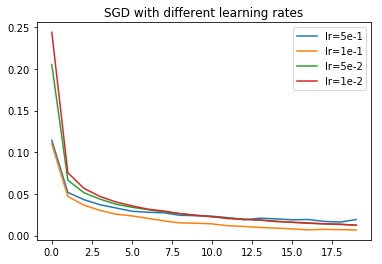

In [63]:
plt.plot(loss_curve_sgd1, label='lr=5e-1')
plt.plot(loss_curve_sgd2, label='lr=1e-1')
plt.plot(loss_curve_sgd3, label='lr=5e-2')
plt.plot(loss_curve_sgd4, label='lr=1e-2')
plt.title('SGD with different learning rates')
plt.legend()
plt.show()

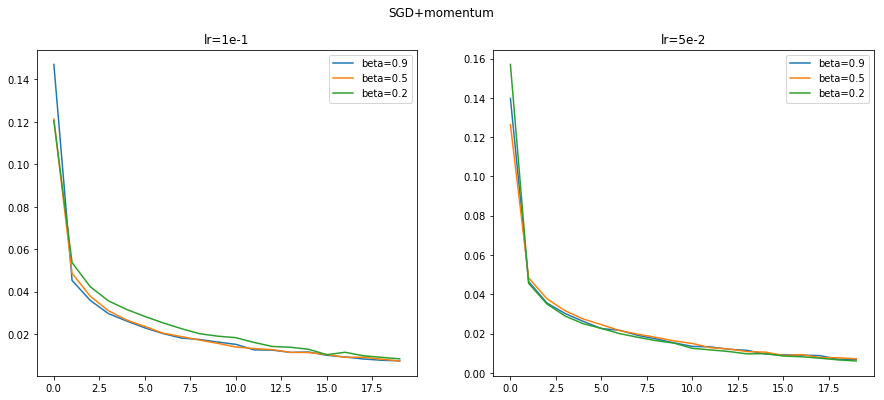

In [64]:
fig, axs = plt.subplots(1,2)
axs[0].plot(loss_curve_sgd_momentum11, label='beta=0.9')
axs[0].plot(loss_curve_sgd_momentum12, label='beta=0.5')
axs[0].plot(loss_curve_sgd_momentum13, label='beta=0.2')
fig.suptitle('SGD+momentum')
axs[0].legend()
axs[0].set_title('lr=1e-1')
axs[1].plot(loss_curve_sgd_momentum21, label='beta=0.9')
axs[1].plot(loss_curve_sgd_momentum22, label='beta=0.5')
axs[1].plot(loss_curve_sgd_momentum23, label='beta=0.2')
axs[1].set_title('lr=5e-2')
axs[1].legend()
fig.set_figwidth(15)
fig.set_figheight(6)
plt.show()

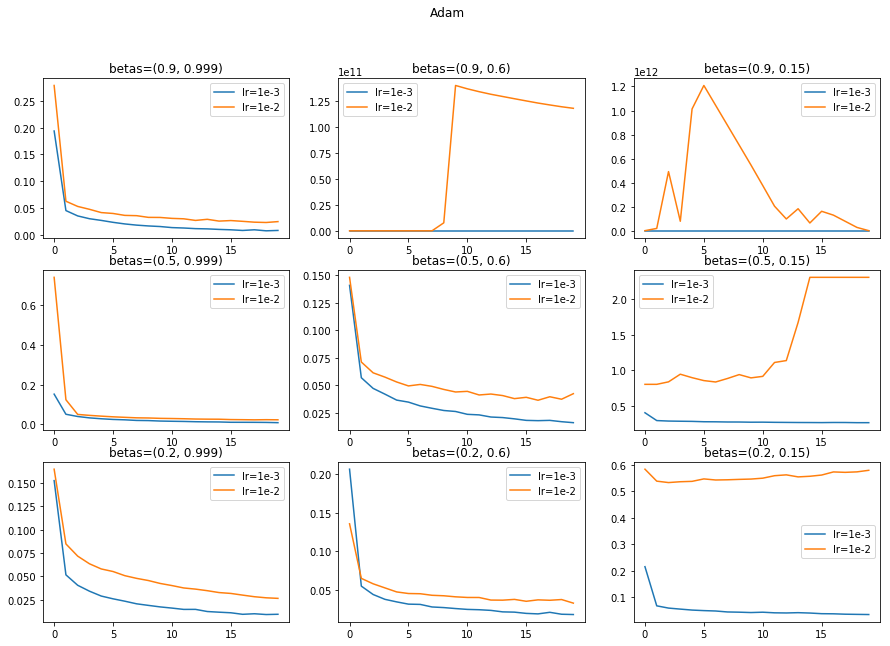

In [65]:
fig, axs = plt.subplots(3,3)
fig.suptitle('Adam')
axs[0][0].plot(loss_curve_adam111, label='lr=1e-3')
axs[0][0].plot(loss_curve_adam112, label='lr=1e-2')
axs[0][0].set_title('betas=(0.9, 0.999)')
axs[0][0].legend()

axs[1][0].plot(loss_curve_adam211, label='lr=1e-3')
axs[1][0].plot(loss_curve_adam212, label='lr=1e-2')
axs[1][0].set_title('betas=(0.5, 0.999)')
axs[1][0].legend()

axs[2][0].plot(loss_curve_adam311, label='lr=1e-3')
axs[2][0].plot(loss_curve_adam312, label='lr=1e-2')
axs[2][0].set_title('betas=(0.2, 0.999)')
axs[2][0].legend()

axs[0][1].plot(loss_curve_adam121, label='lr=1e-3')
axs[0][1].plot(loss_curve_adam122, label='lr=1e-2')
axs[0][1].set_title('betas=(0.9, 0.6)')
axs[0][1].legend()

axs[1][1].plot(loss_curve_adam221, label='lr=1e-3')
axs[1][1].plot(loss_curve_adam222, label='lr=1e-2')
axs[1][1].set_title('betas=(0.5, 0.6)')
axs[1][1].legend()

axs[2][1].plot(loss_curve_adam321, label='lr=1e-3')
axs[2][1].plot(loss_curve_adam322, label='lr=1e-2')
axs[2][1].set_title('betas=(0.2, 0.6)')
axs[2][1].legend()

axs[0][2].plot(loss_curve_adam131, label='lr=1e-3')
axs[0][2].plot(loss_curve_adam132, label='lr=1e-2')
axs[0][2].set_title('betas=(0.9, 0.15)')
axs[0][2].legend()

axs[1][2].plot(loss_curve_adam231, label='lr=1e-3')
axs[1][2].plot(loss_curve_adam232, label='lr=1e-2')
axs[1][2].set_title('betas=(0.5, 0.15)')
axs[1][2].legend()

axs[2][2].plot(loss_curve_adam331, label='lr=1e-3')
axs[2][2].plot(loss_curve_adam332, label='lr=1e-2')
axs[2][2].set_title('betas=(0.2, 0.15)')
axs[2][2].legend()

fig.set_tight_layout()
fig.set_figwidth(15)
fig.set_figheight(10)
plt.show()

### Выводы

На данной выборке скорости сходимости расположены в следущим образом sgd+momentum > sgd > adam.
Видимо это связано с тем, что в данном сете мало мощности выборок различных объектов близки по значению, то есть нет редких объектов. Так же отметим, что в оптимизации Adam при малых значениях коэффициента beta2 ,отвечающего за сколзящее среднее по норме градиента, наблюдаются увеличения функции потерь. Наиболее правдоподобное объяснение этому на мой взгляд выглядит следующим образом. Норма градиента характеризует уверенность продвижения в направлении градиента. Близкий к нулю beta2 означает,что каждый шаг градиентного спуска мы нормируем на норму близкой норме текущего градиента, а если еще и beta1 равен нулю, то получается что каждый шаг градиентного спуска осуществляется на почти нормированный вектор (вроде SGD без момента с нормированным градиентом), что не совсем разумно делать так, как в зависимости от длины градиента нужно двигаться по-разному, а тут эта зависимость стирается.